# Using Machine Learning to Predict Housing Price
### --Siwei Liu

In [1]:
import numpy as np
import pandas as pd
import glob
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import xgboost as xgb
# import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

# Data Cleaning
First, we need to clean the data and do some basic analysis of th raw data.

In [2]:
df = pd.read_excel('Building_bio_modified.xlsx')

In [3]:
df.shape

(1000, 44)

In [4]:
# Drop the duplicates
df.drop_duplicates(subset ="id", keep = "first", inplace = True)
df.reset_index(drop = True, inplace = True)

In [5]:
df.shape

(823, 44)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 44 columns):
id           823 non-null int64
bldname      823 non-null object
address      823 non-null object
detail1      801 non-null object
detail2      803 non-null object
detail3      811 non-null object
detail4      776 non-null object
detail5      35 non-null object
detail6      0 non-null float64
detail2_1    775 non-null object
amnthl1      212 non-null object
amnthl2      136 non-null object
amnthl3      63 non-null object
amnt1        531 non-null object
amnt2        182 non-null object
amnt3        129 non-null object
amnt4        103 non-null object
amnt5        81 non-null object
amnt6        60 non-null object
amnt7        45 non-null object
amnt8        41 non-null object
amnt9        35 non-null object
amnt10       25 non-null object
amnt11       19 non-null object
amnt12       13 non-null object
amnt13       8 non-null object
amnt14       6 non-null object
amnt15       3 non-n

In [7]:
# drop the columns that are not useful
cols_to_drop = ['detail4','detail5','detail6','desc']

for i in range(17, 26):
    cols_to_drop.append('amnt' + str(i))
    
df.drop(columns = cols_to_drop, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 31 columns):
id           823 non-null int64
bldname      823 non-null object
address      823 non-null object
detail1      801 non-null object
detail2      803 non-null object
detail3      811 non-null object
detail2_1    775 non-null object
amnthl1      212 non-null object
amnthl2      136 non-null object
amnthl3      63 non-null object
amnt1        531 non-null object
amnt2        182 non-null object
amnt3        129 non-null object
amnt4        103 non-null object
amnt5        81 non-null object
amnt6        60 non-null object
amnt7        45 non-null object
amnt8        41 non-null object
amnt9        35 non-null object
amnt10       25 non-null object
amnt11       19 non-null object
amnt12       13 non-null object
amnt13       8 non-null object
amnt14       6 non-null object
amnt15       3 non-null object
amnt16       2 non-null object
transp1      823 non-null object
transp2      823 non-n

In [9]:
# Only see the big picture, 
# i.e whether the amentity will influence the housing price, instead of analysing all the amentities 
# since the number of amentity columns is too much
# So, if the amentity column is not na, I code it as score one, and add up the total amentity score.
colname_lst = []
for i in range(1,17):
    colnam = 'amnt' + str(i)
    colname_lst.append(colnam)
df['other_ament_score'] = df[colname_lst].notna().sum(axis=1)

In [10]:
col_to_drop = colname_lst 
df.drop(columns = colname_lst + ['bldname','address'], inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 14 columns):
id                   823 non-null int64
detail1              801 non-null object
detail2              803 non-null object
detail3              811 non-null object
detail2_1            775 non-null object
amnthl1              212 non-null object
amnthl2              136 non-null object
amnthl3              63 non-null object
transp1              823 non-null object
transp2              823 non-null object
transp3              823 non-null object
transp4              823 non-null object
transp5              822 non-null object
other_ament_score    823 non-null int64
dtypes: int64(2), object(12)
memory usage: 90.1+ KB


In [12]:
# Extract the distance (in miles) to transportation station from
# transp1, transp2, transp3, transp4 and transp5
# then take average
df['trans1'] = df.transp1.str.extract('( [0-9][.]*[0-9]{1,2})', expand=True)
df['trans2'] = df.transp2.str.extract('( [0-9][.]*[0-9]{1,2})', expand=True)
df['trans3'] = df.transp3.str.extract('( [0-9][.]*[0-9]{1,2})', expand=True)
df['trans4'] = df.transp4.str.extract('( [0-9][.]*[0-9]{1,2})', expand=True)
df['trans5'] = df.transp5.str.extract('( [0-9][.]*[0-9]{1,2})', expand=True)

# change the data type from object string to float
df['trans1'] = pd.to_numeric(df.trans1)
df['trans2'] = pd.to_numeric(df.trans2)
df['trans3'] = pd.to_numeric(df.trans3)
df['trans4'] = pd.to_numeric(df.trans4)
df['trans5'] = pd.to_numeric(df.trans5)

In [13]:
# if 500 (which means less than 500 feet not 500 miles, replace it by 0.1, since 500 feet is around 0.1 mile)
df.trans1.replace(500.00,0.10, inplace = True)
df.trans2.replace(500.00,0.10, inplace = True)
df.trans3.replace(500.00,0.10, inplace = True)
df.trans4.replace(500.00,0.10, inplace = True)
df.trans5.replace(500.00,0.10, inplace = True)

In [14]:
# Take average of the trans columns
df['trans_average'] = df[['trans1','trans2','trans3','trans4','trans5']].mean(axis=1)

In [15]:
# since we already used the 'trans_average' to represent building transportation convinience feature, drop the redundent features
df.drop(columns=['transp1','transp2','transp3','transp4','transp5','trans1','trans2','trans3','trans4','trans5'], inplace = True)

In [16]:
# reshape the higlighted amenities into tidy format
df['Elevator'] = df.amnthl1.isin(['Elevator'])
df['Elevator'] = df['Elevator'] + df.amnthl2.isin(['Elevator'])
df['Elevator'] = df['Elevator'] + df.amnthl3.isin(['Elevator'])

df['Doorman'] = df.amnthl1.isin(['Doorman', 'Full-time Doorman', 'Part-time Doorman'])
df['Doorman'] = df['Doorman'] + df.amnthl2.isin(['Doorman', 'Full-time Doorman', 'Part-time Doorman'])
df['Doorman'] = df['Doorman'] + df.amnthl3.isin(['Doorman', 'Full-time Doorman', 'Part-time Doorman'])

df['PetsAllowed'] = df.amnthl1.isin(['Cats and Dogs Allowed', 'Pets Allowed'])
df['PetsAllowed'] = df['PetsAllowed'] + df.amnthl2.isin(['Cats and Dogs Allowed', 'Pets Allowed'])
df['PetsAllowed'] = df['PetsAllowed'] + df.amnthl3.isin(['Cats and Dogs Allowed', 'Pets Allowed'])

In [17]:
df.Elevator.replace(False,0,inplace=True)
df.Doorman.replace(False,0,inplace=True)
df.PetsAllowed.replace(False,0,inplace=True)

In [18]:
# Using regular expression to extract numbers in detail1 detail2 and detail3
df['Num_unit'] = df.detail1.str.extract('([0-9]+)', expand=True)
df['Num_story'] = df.detail2.str.extract('([0-9]+)', expand=True)
df['Build_year'] = df.detail3.str.extract('([0-9]+)', expand=True)

In [19]:
df.drop(columns = ['amnthl1','amnthl2','amnthl3','detail1','detail2','detail3'], inplace = True)

In [20]:
# change the column name
df_clean = df.rename(columns = {'detail2_1':'BuildingType'})

In [21]:
df_clean['id'] = df_clean['id'].astype(str)

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 10 columns):
id                   823 non-null object
BuildingType         775 non-null object
other_ament_score    823 non-null int64
trans_average        823 non-null float64
Elevator             823 non-null float64
Doorman              823 non-null float64
PetsAllowed          823 non-null float64
Num_unit             794 non-null object
Num_story            802 non-null object
Build_year           808 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 64.4+ KB


In [23]:
df_clean.shape

(823, 10)

In [24]:
df_clean.head(15)

,id,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year
0,70863,Rental Building,1,0.214,0.0,0.0,0.0,1,4,1915
1,70872,Mixed-Use Building,1,0.318,0.0,0.0,0.0,2,5,1915
2,70962,Co-op,3,0.372,0.0,0.0,0.0,1,2,1920
3,70968,Rental Building,1,0.600,0.0,0.0,0.0,2,3,1901
4,70976,Mixed-Use Building,1,0.710,0.0,0.0,0.0,1,3,1940
5,70979,Three-Family Home,1,0.652,0.0,0.0,0.0,3,4,1899
6,70997,Rental Building,1,0.570,0.0,0.0,0.0,3,3,1939
7,71007,Condo,1,3.170,1.0,0.0,1.0,5,6,2007
8,71028,Rental Building,1,0.400,0.0,0.0,0.0,2,4,1899
9,71031,Condo,1,0.384,0.0,0.0,0.0,2,3,1900


In [25]:
# Get all the 573 files in the 'apt_detail' file
## Should change this path if running on a different computer!
# path = 'apt_detail'
# all_files = glob.glob(path +"/*.csv")
all_files = glob.glob("*.csv")

In [26]:
# Add id lable to each of the 573 csv files and concat them to together into df_csv
df_csv = pd.DataFrame(columns=[0, 1, 2, 3, 4, 'id'])
for filename in all_files:
    csv_name = re.search('([0-9]+\.csv)', filename).group(1)
    dataframe = pd.read_csv(csv_name, header=None)
    dataframe['id'] = csv_name[0:-4]
    df_csv = df_csv.append(dataframe)

In [27]:
df_csv.shape

(24046, 6)

In [28]:
df_csv.head()

,0,1,2,3,4,id
0,#1,"Off-Market on 09/10/2013 at $3,425",3 beds,1 bath,"1,000 ftsq",777217
1,#2,"Off-Market on 03/09/2011 at $2,650",2 beds,1 bath,NaN,777217
2,#4,"Off-Market on 10/20/2013 at $3,050",3 beds,1 bath,800 ftsq,777217
3,#6B,"Off-Market on 08/01/2013 at $3,050",2 beds,1 bath,NaN,777217
4,#8B,"Off-Market on 12/20/2013 at $3,025",1 bed,1 bath,NaN,777217


In [29]:
# merge the concatenated csv file and the maid data frame together
df_clean = pd.merge(df_clean, df_csv, on = 'id', how = 'outer')

In [30]:
df_clean.shape

(24296, 15)

In [31]:
df_clean.head()

,id,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,0,1,2,3,4
0,70863,Rental Building,1,0.214,0.0,0.0,0.0,1,4,1915,#1,"Off-Market on 08/12/2011 at $35,000",4 beds,4 baths,"6,435 ftsq"
1,70872,Mixed-Use Building,1,0.318,0.0,0.0,0.0,2,5,1915,#345,"Off-Market on 06/22/2009 at $7,800",studio,1 bath,"3,000 ftsq"
2,70872,Mixed-Use Building,1,0.318,0.0,0.0,0.0,2,5,1915,#THOUSE,"Off-Market on 03/03/2017 at $18,745",4 beds,4.5 baths,"4,400 ftsq"
3,70962,Co-op,3,0.372,0.0,0.0,0.0,1,2,1920,#2FE,"Sold on 10/20/2011 for $250,000",studio,1 bath,NaN
4,70962,Co-op,3,0.372,0.0,0.0,0.0,1,2,1920,#4B,"Off-Market on 12/12/2016 at $2,600",studio,1 bath,600 ftsq


In [32]:
# rename the columns
df_clean.rename(columns = {0:'Floor', 1:'Sold_price', 2:'Num_bedroom', 3:'Num_bathroom',4:'SquareFeet'}, inplace = True)

In [33]:
# add a new column indicating whether the room is studio or not, and set studio in the Num_bedroom to be 1
df_clean['Studio'] = df_clean['Num_bedroom'].isin(['studio'])
df_clean.Studio.replace(False, 0, inplace=True)

# set studio in the Num_bedroom to be 1
df_clean.Num_bedroom.replace('studio', 1, inplace = True)

In [34]:
### Extract the numbers in the columns: Num_bedroom, Num_bathroom, SquareFeet

# Num_bedroom
df_clean.Num_bedroom = df_clean.Num_bedroom.astype(str)
df_clean['Num_bedroom'] = df_clean.Num_bedroom.str.extract('([0-9.]+)', expand=True)

# Num_bathroom
df_clean['Num_bathroom'] = df_clean.Num_bathroom.str.extract('([0-9.]+)', expand=True)

# SquareFeet
df_clean.SquareFeet.replace('[,]','',regex=True, inplace = True)
df_clean['SquareFeet'] = df_clean.SquareFeet.str.extract('([0-9.,]+)', expand=True)

# change the data type of Num_bedroom, Num_bathroom, SquareFeet to float
df_clean.Num_bedroom = df_clean.Num_bedroom.astype(float)
df_clean.Num_bathroom = df_clean.Num_bathroom.astype(float)
df_clean.SquareFeet = df_clean.SquareFeet.astype(float)

In [35]:
# Extract the floor number
df_clean['Floor'] = df_clean.Floor.str.extract('([0-9.]+)', expand=True)
df_clean.Floor = df_clean.Floor.astype(float)

In [36]:
# Since there are a lot of very big numbers in the Floor column, 
# I suspect my understanding of this column may be incorrect,
# If I have more time I will investigate more on this issue
# For now, I decide to leave it out first
len(df_clean[df_clean['Floor'] > 50])
df_analysis = df_clean.drop(columns = ['Floor'])

In [37]:
# Extract the sold price, since we need to use the sold price as the dependent variable when training the model
# abandon the off-market ones for now, since it's just the suggested price not the actual sold price
df_analysis = df_analysis[df_analysis['Sold_price'].str.contains('Sold') == True]

In [38]:
df_analysis.head()

,id,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
3,70962,Co-op,3,0.372,0.0,0.0,0.0,1,2,1920,"Sold on 10/20/2011 for $250,000",1.0,1.0,NaN,1.0
20,71007,Condo,1,3.170,1.0,0.0,1.0,5,6,2007,Sold on 04/15/2014 for $1,NaN,NaN,NaN,0.0
21,71007,Condo,1,3.170,1.0,0.0,1.0,5,6,2007,"Sold on 03/16/2009 for $1,525,000",2.0,2.0,1295.0,0.0
24,71007,Condo,1,3.170,1.0,0.0,1.0,5,6,2007,"Sold on 03/12/2009 for $1,221,900",2.0,2.0,1295.0,0.0
26,71007,Condo,1,3.170,1.0,0.0,1.0,5,6,2007,"Sold on 05/15/2017 for $1,875,000",NaN,NaN,NaN,0.0


In [39]:
df_analysis.drop(df_analysis[df_analysis['SquareFeet'] > 50000].index, axis=0, inplace=True)

In [40]:
# Extract the sold price number
df_analysis['Sold_price'] = df_analysis.Sold_price.str.extract('(\$[0-9,.]+)', expand=True)

# get rid of the dollar sign and comma
df_analysis.Sold_price.replace('[\$,]','',regex=True, inplace = True)

# change the data type to float
df_analysis.Sold_price = df_analysis.Sold_price.astype(float)

In [41]:
# final check before the analysis: change the other columns into the right data type
df_analysis.Num_unit = df_analysis.Num_unit.astype(float)
df_analysis.Num_story = df_analysis.Num_story.astype(float)
df_analysis.Build_year = df_analysis.Build_year.astype(float)

# Check the dataframe for analysis

In [42]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5776 entries, 3 to 24090
Data columns (total 15 columns):
id                   5776 non-null object
BuildingType         5771 non-null object
other_ament_score    5776 non-null int64
trans_average        5776 non-null float64
Elevator             5776 non-null float64
Doorman              5776 non-null float64
PetsAllowed          5776 non-null float64
Num_unit             5707 non-null float64
Num_story            5558 non-null float64
Build_year           5754 non-null float64
Sold_price           5776 non-null float64
Num_bedroom          3066 non-null float64
Num_bathroom         3054 non-null float64
SquareFeet           4207 non-null float64
Studio               5776 non-null float64
dtypes: float64(12), int64(1), object(2)
memory usage: 722.0+ KB


In [43]:
# Since there are a lot of values which are not feasible, 
# i.e. not quite possible to sell the house for $0 or $1 or $ 400
# So I just recode these values as NaN in order to not let this outliers influence the analysis
df_analysis['Sold_price'].values[df_analysis['Sold_price'] <= 5000] = None

In [44]:
df_analysis['Sold_price'].describe()

count    5.138000e+03
mean     4.373785e+06
std      1.670787e+07
min      9.790000e+03
25%      6.300000e+05
50%      1.200000e+06
75%      2.550537e+06
max      2.740000e+08
Name: Sold_price, dtype: float64

In [45]:
df_analysis.head(10)

,id,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
3,70962,Co-op,3,0.372,0.0,0.0,0.0,1.0,2.0,1920.0,250000.0,1.0,1.0,NaN,1.0
20,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,NaN,NaN,NaN,NaN,0.0
21,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1525000.0,2.0,2.0,1295.0,0.0
24,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1221900.0,2.0,2.0,1295.0,0.0
26,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1875000.0,NaN,NaN,NaN,0.0
28,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1200000.0,NaN,NaN,NaN,0.0
29,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,NaN,NaN,NaN,NaN,0.0
30,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,840000.0,NaN,NaN,NaN,0.0
32,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1795000.0,2.0,2.5,1628.0,0.0
35,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1795000.0,2.0,2.5,1628.0,0.0


In [46]:
df_analysis.describe()

,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
count,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5707.000000,5558.000000,5754.000000,5.138000e+03,3066.000000,3054.000000,4207.000000,5776.000000
mean,6.826524,1.950610,0.895602,0.792936,0.722299,202.852637,22.544081,1886.639208,4.373785e+06,1.871168,1.875082,1429.517709,0.055575
std,4.081469,12.600362,0.305802,0.405237,0.447904,191.783116,14.100597,381.496071,1.670787e+07,1.005144,0.963142,1665.220350,0.229119
min,0.000000,0.116000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,9.790000e+03,1.000000,1.000000,1.000000,0.000000
25%,4.000000,0.234000,1.000000,1.000000,0.000000,54.000000,10.000000,1915.000000,6.300000e+05,1.000000,1.000000,682.000000,0.000000
50%,6.000000,0.270000,1.000000,1.000000,1.000000,157.000000,21.000000,1985.000000,1.200000e+06,2.000000,2.000000,1022.000000,0.000000
75%,10.000000,0.346000,1.000000,1.000000,1.000000,253.000000,31.000000,2003.000000,2.550537e+06,2.000000,2.500000,1681.000000,0.000000
max,16.000000,173.600000,1.000000,1.000000,1.000000,880.000000,65.000000,2018.000000,2.740000e+08,18.000000,10.000000,32843.000000,1.000000


In [47]:
# There are also 224 values whoes built year is less than 1000, and a lot of which are 2, etc, 
# which is not feasable, so I recode these values to NaN
df_analysis['Build_year'].values[df_analysis['Build_year'] <= 1000] = None

# Squarefeet less than 100 sold for high price is not feasible, recode them with NaN for now
df_analysis['SquareFeet'].values[df_analysis['SquareFeet'] <= 50] = None

In [48]:
df_analysis.describe()

,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
count,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5707.000000,5558.000000,5530.000000,5.138000e+03,3066.000000,3054.000000,4186.000000,5776.000000
mean,6.826524,1.950610,0.895602,0.792936,0.722299,202.852637,22.544081,1962.975045,4.373785e+06,1.871168,1.875082,1436.593407,0.055575
std,4.081469,12.600362,0.305802,0.405237,0.447904,191.783116,14.100597,41.512982,1.670787e+07,1.005144,0.963142,1666.385604,0.229119
min,0.000000,0.116000,0.000000,0.000000,0.000000,1.000000,1.000000,1852.000000,9.790000e+03,1.000000,1.000000,53.000000,0.000000
25%,4.000000,0.234000,1.000000,1.000000,0.000000,54.000000,10.000000,1920.000000,6.300000e+05,1.000000,1.000000,685.000000,0.000000
50%,6.000000,0.270000,1.000000,1.000000,1.000000,157.000000,21.000000,1985.000000,1.200000e+06,2.000000,2.000000,1024.000000,0.000000
75%,10.000000,0.346000,1.000000,1.000000,1.000000,253.000000,31.000000,2003.000000,2.550537e+06,2.000000,2.500000,1681.000000,0.000000
max,16.000000,173.600000,1.000000,1.000000,1.000000,880.000000,65.000000,2018.000000,2.740000e+08,18.000000,10.000000,32843.000000,1.000000


In [49]:
# df_analysis['Sold_price'] = df_analysis['Sold_price'].fillna(0)

In [50]:
df_analysis.shape

(5776, 15)

# Explorative Data Analysis

In [51]:
df_analysis.head()

,id,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
3,70962,Co-op,3,0.372,0.0,0.0,0.0,1.0,2.0,1920.0,250000.0,1.0,1.0,NaN,1.0
20,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,NaN,NaN,NaN,NaN,0.0
21,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1525000.0,2.0,2.0,1295.0,0.0
24,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1221900.0,2.0,2.0,1295.0,0.0
26,71007,Condo,1,3.170,1.0,0.0,1.0,5.0,6.0,2007.0,1875000.0,NaN,NaN,NaN,0.0


In [52]:
df_analysis.BuildingType.value_counts()

Condo                 5112
Co-op                  606
Other type              41
Rental Building          7
Single-Family Home       4
Multi-family             1
Name: BuildingType, dtype: int64

In [53]:
# df_analysis[df_analysis['BuildingType'] =='Rental Building']
df_analysis.drop(df_analysis.loc[df_analysis['BuildingType'].isin(['Rental Building','Single-Family Home','Multi-family'])].index, inplace=True)

In [54]:
df_analysis.BuildingType.value_counts()

Condo         5112
Co-op          606
Other type      41
Name: BuildingType, dtype: int64

In [55]:
df_analysis.shape

(5764, 15)

In [56]:
train, test = train_test_split(df_analysis, test_size=0.3)

In [57]:
train.head()

,id,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
11839,777196,Condo,3,0.234,1.0,1.0,1.0,145.0,26.0,1927.0,950000.0,NaN,NaN,NaN,0.0
9000,776211,Condo,10,0.124,1.0,1.0,1.0,382.0,42.0,1914.0,2612500.0,2.0,2.5,2079.0,0.0
1659,773092,Condo,12,0.258,1.0,1.0,1.0,247.0,33.0,2008.0,1825000.0,2.0,2.0,1321.0,0.0
5302,775512,Condo,8,0.274,1.0,1.0,1.0,121.0,9.0,1985.0,645000.0,1.0,1.0,622.0,0.0
15293,778633,Condo,2,0.180,1.0,1.0,1.0,5.0,9.0,1915.0,NaN,NaN,NaN,8828.0,0.0


In [58]:
# Save the 'id' column
train_ID = train['id']
test_ID = test['id']

# Now drop the 'id' column since it's unnecessary for the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

# Check data size after dropping the 'id' variable
print("The train data size after dropping id feature is : {} ".format(train.shape)) 
print("The test data size after dropping id feature is : {} ".format(test.shape))

The train data size after dropping id feature is : (4034, 14) 
The test data size after dropping id feature is : (1730, 14) 


In [59]:
# Analyzing the Test Variable (Sale Price)
# Getting Description 
train['Sold_price'].describe()

count    3.595000e+03
mean     4.445963e+06
std      1.702482e+07
min      9.790000e+03
25%      6.300000e+05
50%      1.206626e+06
75%      2.578132e+06
max      2.740000e+08
Name: Sold_price, dtype: float64


 mu = 4445963.48 and sigma = 17022452.17



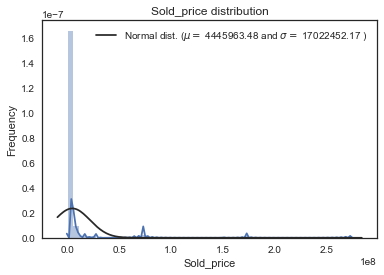

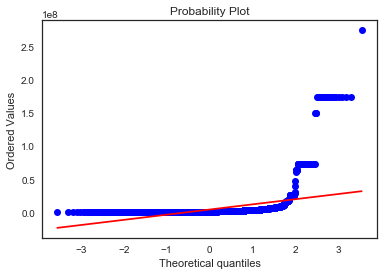

Skewness: 8.285591
Kurtosis: 79.215767


In [60]:
# Plot Histogram
sns.distplot(train['Sold_price'].dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Sold_price'].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sold_price distribution')

fig = plt.figure()
res = stats.probplot(train['Sold_price'].dropna(), plot=plt)
plt.show()

print("Skewness: %f" % train['Sold_price'].dropna().skew())
print("Kurtosis: %f" % train['Sold_price'].dropna().kurt())

From the plot above, we can see the data are skewed. Later we used some transformation on the raw data in order to fix it.

Next, we would like to look at the correlation between different predictors in the dataset. To visulaze the relationship among them, we used heatmap.

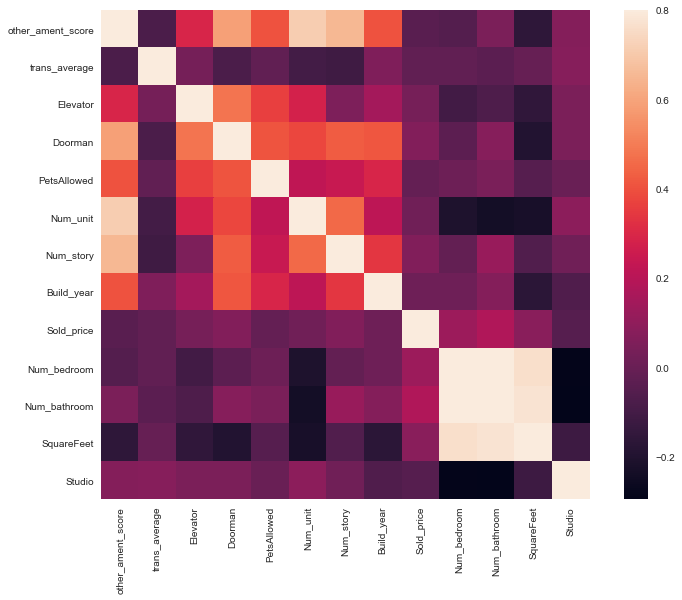

In [61]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

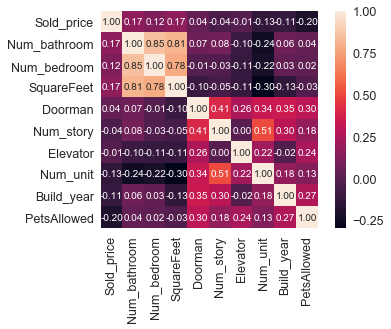

In [62]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Sold_price')['Sold_price'].dropna().index
cm = np.corrcoef(train[cols].dropna().values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Then we would like to explore the sold price of the house with different building type. From the picture below we can see "Condo" houses are more expensive than "Co-op" buildings. Also, "Condo" type of houses have any outliers, which means the price difference in this type of house is bigger than the other 2 types.

(-0.5, 2.5, 0, 20000000)

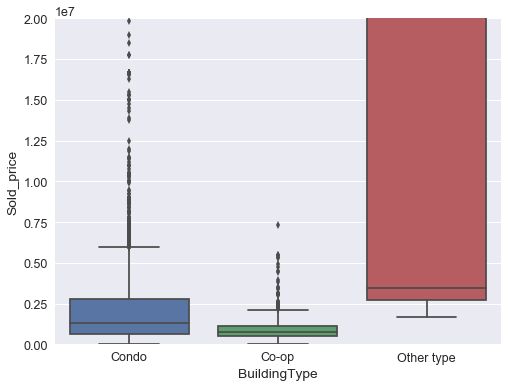

In [63]:
# Overall Quality vs Sale Price
var = 'BuildingType'
data = pd.concat([train['Sold_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Sold_price", data=data)
fig.axis(ymin=0, ymax=20000000)

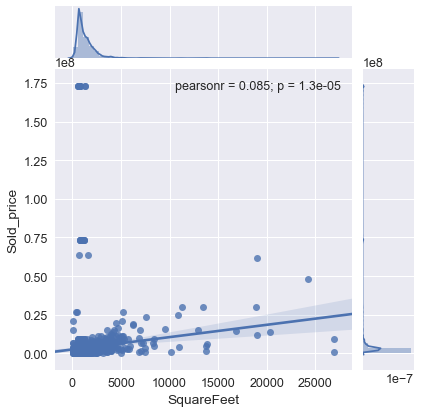

In [64]:
# SquareFeet vs Sold_price
sns.jointplot(x=train['SquareFeet'], y=train['Sold_price'], kind='reg')

In [65]:
# drop the rows whoes sold price is NaN
df_analysis.dropna(subset=['Sold_price'], inplace = True)

In [66]:
df_analysis.shape

(5128, 15)

Next step is to deal with the missing vales. We need to either remove them or fill them with values like mean or median.

In [67]:
# Find Missing Ratio of Dataset
df_analysis_na = (df_analysis.isnull().sum() / len(df_analysis)) * 100
df_analysis_na = df_analysis_na.drop(df_analysis_na[df_analysis_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_analysis_na})
missing_data

,Missing Ratio
Num_bathroom,44.988300
Num_bedroom,44.793292
SquareFeet,26.891576
Build_year,4.387676
Num_story,3.724649
Num_unit,0.877535
BuildingType,0.097504


Text(0.5,1,'Percent missing data by feature')

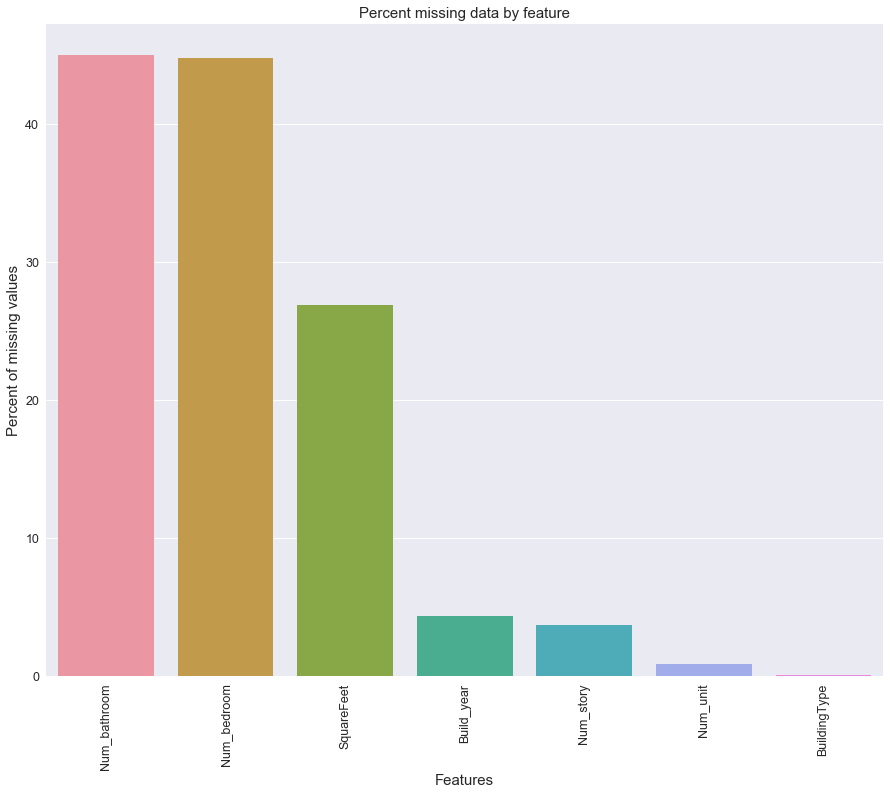

In [68]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=df_analysis_na.index, y=df_analysis_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Since there are only 5 missing values in BuildingType, fill the missing value in this column with the most frequent category, which is Condo.

In [69]:
df_analysis.BuildingType.isnull().sum()


5

In [70]:
df_analysis.BuildingType.value_counts()
# the most frequent type is Condo, so I will fill these 5 missing values with the type Condo

Condo         4564
Co-op          541
Other type      18
Name: BuildingType, dtype: int64

In [71]:
df_analysis.BuildingType.fillna('Condo',inplace = True)

Since Num_bathroom and Num_bedroom are of the most important features to predict the housing price, 
yet there are around 50% missing values. Luckily we have more than 5000 rows of data, I decide to drop the rows 
in which Num_bathroom or Num_bedroom are NaN 

In [72]:

df_analysis.dropna(subset=['Num_bathroom'], inplace = True)
df_analysis.dropna(subset=['Num_bedroom'], inplace = True)
df_analysis.dropna(subset=['SquareFeet'], inplace = True)

In [73]:
# We still have around 3000 rows left
df_analysis.shape

(2629, 15)

Use the median value to fill in the NaN values in columns: Num_story and Num_unit



In [74]:
Num_story_median = df_analysis.Num_story.median()
Num_unit_median = df_analysis.Num_unit.median()

df_analysis.Num_story.fillna(Num_story_median ,inplace = True)
df_analysis.Num_unit.fillna(Num_unit_median ,inplace = True)

In [75]:
# For Build_year, turn it into str first and then fill the NaN values with the most frequent values
df_analysis['Build_year'] = df_analysis.Build_year.astype('str')
# 1985 is the most frequent Build_year
df_analysis.Build_year.fillna('1985', inplace = True)

In [76]:
# Check and make sure there is no missing values in the data frame
df_analysis_na = (df_analysis.isnull().sum() / len(df_analysis)) * 100
df_analysis_na

id                   0.0
BuildingType         0.0
other_ament_score    0.0
trans_average        0.0
Elevator             0.0
Doorman              0.0
PetsAllowed          0.0
Num_unit             0.0
Num_story            0.0
Build_year           0.0
Sold_price           0.0
Num_bedroom          0.0
Num_bathroom         0.0
SquareFeet           0.0
Studio               0.0
dtype: float64

In [77]:
np.random.seed(5)
train, test = train_test_split(df_analysis, test_size=0.3)
print(len(train))
print(len(test))

1840
789


In [78]:
# Save the 'id' column
train_ID = train['id']
test_ID = test['id']

# Now drop the 'id' column since it's unnecessary for the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

# Check data size after dropping the 'id' variable
print("The train data size after dropping id feature is : {} ".format(train.shape)) 
print("The test data size after dropping id feature is : {} ".format(test.shape))

The train data size after dropping id feature is : (1840, 14) 
The test data size after dropping id feature is : (789, 14) 


In [79]:
train.head()

,BuildingType,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Build_year,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
18546,Condo,3,0.238,1.0,0.0,0.0,5.0,7.0,1891.0,4625000.0,3.0,2.5,4058.0,0.0
21041,Co-op,14,0.402,1.0,1.0,1.0,880.0,20.0,1960.0,496000.0,1.0,1.0,800.0,0.0
7545,Condo,11,0.150,1.0,1.0,0.0,452.0,37.0,1929.0,1350000.0,1.0,1.0,881.0,0.0
3208,Condo,9,0.406,1.0,1.0,1.0,168.0,28.0,2001.0,2708545.0,3.0,2.0,726.0,0.0
2938,Condo,9,0.406,1.0,1.0,1.0,168.0,28.0,2001.0,1476462.0,2.0,2.0,1049.0,0.0



 mu = 2732303.94 and sigma = 7065858.50



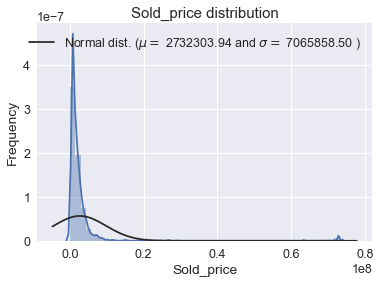

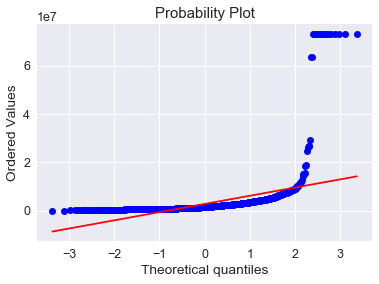

Skewness: 8.858287
Kurtosis: 83.341326


In [80]:
# Plot Histogram
sns.distplot(train['Sold_price'].dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Sold_price'].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sold_price distribution')

fig = plt.figure()
res = stats.probplot(train['Sold_price'].dropna(), plot=plt)
plt.show()

print("Skewness: %f" % train['Sold_price'].dropna().skew())
print("Kurtosis: %f" % train['Sold_price'].dropna().kurt())


 mu = 14.24 and sigma = 0.89



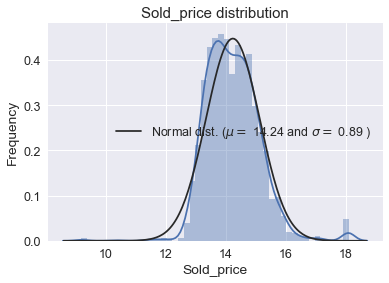

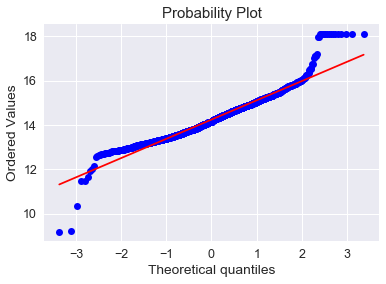

Skewness: 0.658023
Kurtosis: 3.389776


In [81]:
train["Sold_price"] = np.log1p(train["Sold_price"])

#Check the new distribution 
sns.distplot(train['Sold_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Sold_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sold_price distribution')

fig = plt.figure()
res = stats.probplot(train['Sold_price'], plot=plt)
plt.show()

y_train = train.Sold_price.values

print("Skewness: %f" % train['Sold_price'].skew())
print("Kurtosis: %f" % train['Sold_price'].kurt())

Now we start to fix the skewing issue: skewed data to be more normal so that our models will be more accurate when making predictions
We used the numpy fuction log1p which applies log(1+x) to all elements of the column

In [82]:
numeric_feats = df_analysis.dtypes[df_analysis.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_analysis[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
Sold_price,8.460791
trans_average,7.856517
SquareFeet,3.894654
Studio,2.680115
Num_unit,1.400012


Apply the box-cox transformation to solve the skewness problem

In [83]:
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_analysis[feat] = boxcox1p(df_analysis[feat], lam)
    df_analysis[feat] += 1

There are 12 skewed numerical features to Box Cox transform


# Model Performance

In [84]:
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [85]:
train_y = train.Sold_price
train_x = train.drop(['BuildingType','Build_year'], 1)
# Here I dropped buildyear as it's too big and not so meaningful.

In [86]:
train_x.head()

,other_ament_score,trans_average,Elevator,Doorman,PetsAllowed,Num_unit,Num_story,Sold_price,Num_bedroom,Num_bathroom,SquareFeet,Studio
18546,3,0.238,1.0,0.0,0.0,5.0,7.0,15.346987,3.0,2.5,4058.0,0.0
21041,14,0.402,1.0,1.0,1.0,880.0,20.0,13.114333,1.0,1.0,800.0,0.0
7545,11,0.150,1.0,1.0,0.0,452.0,37.0,14.115616,1.0,1.0,881.0,0.0
3208,9,0.406,1.0,1.0,1.0,168.0,28.0,14.811923,3.0,2.0,726.0,0.0
2938,9,0.406,1.0,1.0,1.0,168.0,28.0,14.205160,2.0,2.0,1049.0,0.0


In [87]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [88]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)

Checking performance of base models by evaluating the cross-validation RMSLE error.

In [89]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Lasso score: 0.0007 (0.0001)

Kernel Ridge score: 0.0007 (0.0001)

Gradient Boosting score: 0.1314 (0.0960)

Xgboost score: 0.1110 (0.0694)



From the result we can see, in our case Laaso and Kernel Ridge regression performs better than Gradient Boosting and XGBoosting methods.

## Citataion

1. Diogo Menezes Borges. Retrieved from : https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6

2. Suryanand Singh. Retrived from : https://www.kaggle.com/surya635/house-price-prediction